In [1]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import models
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import argparse
import os
import tqdm
import scipy.ndimage as nd
from torchvision import transforms

In [2]:
force_cpu = False
if torch.cuda.is_available() and not force_cpu:  
    device = "cuda:0"
else:  
    device = "cpu"
device = torch.device(device)
print(device)

cuda:0


In [3]:
class UnNormalize(object): #from https://discuss.pytorch.org/t/simple-way-to-inverse-transform-normalization/4821
    def __init__(self, mean, std):
        self.mean = mean
        self.std = std

    def __call__(self, tensor):
        for t, m, s in zip(tensor, self.mean, self.std):
            t.mul_(s).add_(m)
            # The normalize code -> t.sub_(m).div_(s)
        return tensor

mean = torch.tensor([0.485, 0.456, 0.406], device=device)
std = torch.tensor([0.229, 0.224, 0.225], device=device)

toTensor = transforms.ToTensor()
toPIL = transforms.ToPILImage()
normalize = transforms.Normalize(mean, std)
unnormalize = UnNormalize(mean, std)

In [4]:
def toPILImage(image):
    image = image.detach().clone()
    image = unnormalize(image[0])
    image = image.clamp(0, 1)
    image = toPIL(image.cpu())
    return image
def showImage(image, size=None, save=False):
    image = toPILImage(image)
    fig = plt.figure(figsize=size)
    plt.axis("off")
    plt.imshow(image)
    if save:
        plt.savefig("asdf.png")

In [5]:
def dream(image, iterations, learning_rate):
    image.requires_grad = True
    for i in range(iterations):
        network.zero_grad()
        out = network(image)
        
        loss = out.norm()
        loss.backward()
        
        avg_grad = torch.mean(torch.abs(image.grad.data)).item()

        image.data += (learning_rate / avg_grad) * image.grad.data
        image.grad.data.zero_()

        image.requires_grad = False
        image = unnormalize(image[0])
        image = image.clamp(0, 1)
        image = normalize(image)
        image = image.unsqueeze(0)
        image.requires_grad = True

        print("{} ".format(i + 1), end="")
    print()
    image.requires_grad = False
    return image

In [6]:
def dreamOctaves(input_image, parameter_group):
    layer_cut, learning_rate, octave_scale, octaves, iterations = parameter_group
    scale_factor = 450.0 / input_image.size()[2]
    input_image = torch.nn.functional.interpolate(input_image, scale_factor=scale_factor, mode="bicubic",
                                                align_corners=True, recompute_scale_factor=True)

    print("After initial scaling: {}".format((input_image.size()[3], input_image.size()[2])))

    images = [input_image.detach().clone()]

    for i in range(octaves - 1):
        previous_image = images[-1]
        size =(round(previous_image.size()[2] * (1.0 / octave_scale)), round(previous_image.size()[3] * (1.0 / octave_scale)))
        smaller_image = torch.nn.functional.interpolate(previous_image, size=size, mode="bicubic",
                                                align_corners=True, recompute_scale_factor=True)
        images.append(smaller_image)
    images.reverse()

    print("Min octave size: {}".format((images[0].size()[3], images[0].size()[2])))

    difference = torch.zeros_like(images[0])
    for octave, image in enumerate(images):
        
        size = (image.size()[2], image.size()[3])
        difference = torch.nn.functional.interpolate(difference, size=size, mode="bicubic",
                                                align_corners=True, recompute_scale_factor=True)

        image -= difference

        print("octave: {}".format(octave + 1))

        dreamed_image = dream(image.detach().clone(), iterations, learning_rate)
        new_difference = image - dreamed_image
        difference += new_difference
    return dreamed_image

In [7]:
def dreamUpscale(input_image, parameter_group):
    layer_cut, learning_rate, octave_scale, octaves, iterations = parameter_group
    scale_factor = 35.0 / input_image.size()[2]
    input_image = torch.nn.functional.interpolate(input_image, scale_factor=scale_factor, mode="bicubic",
                                                align_corners=True, recompute_scale_factor=True)

    print("After initial scaling: {}".format((input_image.size()[3], input_image.size()[2])))
    
    image = input_image
    octave = 0
    while image.size()[2] <= 450:
        if octave != 0:
            image = torch.nn.functional.interpolate(image, scale_factor=octave_scale, mode="bicubic",
                                                align_corners=True, recompute_scale_factor=True)

        print("octave: {}".format(octave + 1))
        image = dream(image.detach().clone(), iterations, learning_rate)
        octave += 1
        if octave == octaves:
            break
    
    print("Output size: {}".format((image.size()[3], image.size()[2])))
    
    return input_image, image

In [8]:
def dreamUpscaleUncapped(input_image, parameter_group, upscale_scale, upscale_iterations):
    layer_cut, learning_rate, octave_scale, octaves, iterations = parameter_group
    
    image = input_image
    for i in range(upscale_iterations):
        image = torch.nn.functional.interpolate(image, scale_factor=upscale_scale, mode="bicubic",
                                            align_corners=True, recompute_scale_factor=True)

        print("octave: {}".format(i + 1))
        image = dream(image.detach().clone(), iterations, learning_rate)
    
    print("Output size: {}".format((image.size()[3], image.size()[2])))
    
    return image

Input image size: (1200, 1788)
torch.Size([3, 1788, 1200])
After initial scaling: (302, 450)
Min octave size: (17, 26)
octave: 1
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 
octave: 2
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 
octave: 3
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 
octave: 4
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 
octave: 5
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 
octave: 6
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 
octave: 7
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 
octave: 8
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 


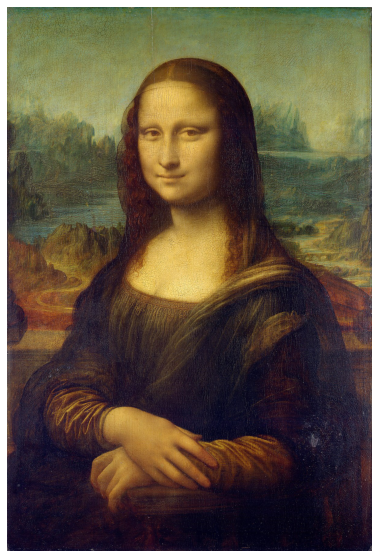

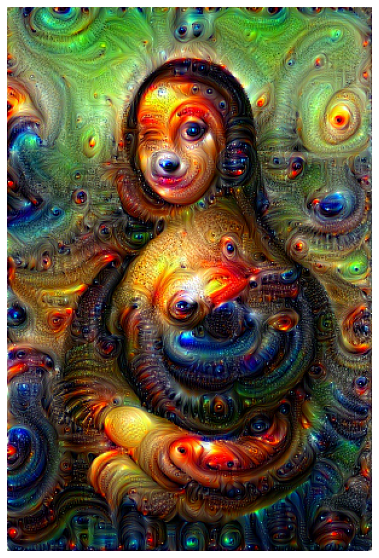

In [16]:
#layer_cut, learning_rate, octave_scale, octaves, itertaions
default = (26, 0.005, 1.5, 8, 30)
default2 = (31, 0.0055, 1.5, 9, 30)
circles = (17, 0.0075, 1.5, 8, 30)
lines = (15, 0.0075, 1.5, 8, 30)
quick = (26, 0.0025, 1.5, 3, 30)

image_name = "SampleImages\\lisa.jpg"
parameter_group = circles
method = 0 #0=octaves, 1=upscale, 2=upscale_uncapped

layer_cut, learning_rate, octave_scale, octaves, iterations = parameter_group

network = models.vgg19(pretrained=True).to(device)
for param in network.parameters():
    param.require_grad = False
layers = list(network.features.children())
network = nn.Sequential(*layers[: (layer_cut + 1)])

input_image = Image.open(image_name)
input_image = input_image.convert("RGB")
print("Input image size: {}".format(input_image.size))
input_image = toTensor(input_image).to(device)
print(input_image.size())
input_image = normalize(input_image)
input_image = input_image.unsqueeze(0) #single image to batch of size one [3, width, height] -> [1, 3, width, height]

if method == 0:
    dreamed_image = dreamOctaves(input_image, parameter_group)
elif method == 1:
    input_image, dreamed_image = dreamUpscale(input_image, parameter_group)
else:
    dreamed_image = dreamUpscaleUncapped(input_image, parameter_group, 1.5, 6)

showImage(input_image, (10, 10))
showImage(dreamed_image, (10, 10))
toPILImage(dreamed_image).save("out.jpg")